# Statistical Analysis: NHST

#### **TODO**: move pre-process functions into analysis_utils module

## Data loading & pre-processing

In [7]:
import pandas as pd
import re

import analysis_utils as utils

Load data from all `../res` sub-directories (treatments):

In [8]:
summary_dfs = {}    # dict to store statistical summary data (<session_name>.json)
all_data_dfs = {}   # dict to store all individual measurements (all_data_<session_name>.json)

experiment_data_dir = '../res' # directory generated by "eval.py", contains the .json files with the experiment data

# Load all the experiment data
summary_dfs, all_data_dfs = utils.load_experiment_data(experiment_data_dir, iteration_structure=True)

### Flatten GPU and VRAM columns 
These contains nested objects and values.
We are only interested in a subset of the contained data.

In [39]:
def flatten_gpu_vram_columns(df: pd.DataFrame) -> pd.DataFrame:
    # TODO: fix the key for extracting "vram_max_usage_mib" from "max_consumed_MiB" -> new format (check repo)
    
    # GPU columns
    df["gpu_util_mean"] = df["GPU"].apply(lambda x: x["utilization"]["avg"] if isinstance(x, dict) else None)
    df["gpu_util_max"]  = df["GPU"].apply(lambda x: x["utilization"]["max"] if isinstance(x, dict) else None)

    # VRAM columns
    df["vram_util_mean"]     = df["VRAM"].apply(lambda x: x["utilization"]["avg"] if isinstance(x, dict) else None)
    df["vram_util_max"]      = df["VRAM"].apply(lambda x: x["utilization"]["max"] if isinstance(x, dict) else None)
    df["vram_max_usage_mib"] = df["VRAM"].apply(lambda x: x["max_consumed_MiB"]   if isinstance(x, dict) else None) #TODO: FIX KEY

    # Drop the redundant columns
    df = df.drop(columns=["GPU", "VRAM"])

    return df

### Convert data to long format

In [ ]:
def convert_dict_dfs_to_long(dictionary_dataframes: dict[pd.DataFrame], metrics_of_interest: list[str]) -> pd.DataFrame:
    rows = [] # temporary list to hold all constructed rows of data

    # Iterate through each treatment and corresponding data
    for treatment_name, df in dictionary_dataframes.items():

        # Extract the treatment factors (dataset is a blocked variable)
        model, quant, dataset = treatment_name.split("_")
        
        for i, row in df.iterrows():
            # Extract iteration from last dir in data_path (e.g. "01" from ".../01", etc.)
            match = re.search(r"/(\d{2})$", row["data_path"])
            iteration = int(match.group(1)) if match else i + 1 # TODO: should we include the fallback or let it fail?

            # Construct row dictionary
            row_data = {
                #"treatment": treatment_name, #FIXME: redundant
                "model": model, 
                "quantization": quant, 
                "dataset": dataset,
                "iteration": iteration
            }
        
            # Add relevant metrics
            for metric in metrics_of_interest:
                row_data[metric] = row[metric]

            rows.append(row_data)

    # Combine all the rows of data into a single long-format dataframe
    long_dataframe: pd.DataFrame = pd.DataFrame(rows)

    return long_dataframe

### Flatten columns and convert to long format to prepare for NHST analysis

In [ ]:
# Metrics to extract (for RQ1)
RQ1_efficacy_metrics = [
    "accuracy", "recall", 
    "precision", "f1",
    "balanced_accuracy", 
    "specificity"   
]

# Metrics to extract (for RQ2)
RQ2_efficiency_metrics = [
    "time_to_analyze",
    "gpu_util_mean", "gpu_util_max",
    "vram_util_mean", "vram_util_max",
    "vram_max_usage_mib"
]

# Flatten and extract the relevant GPU and VRAM metrics into distinct columns (they are intially nested objects)
flattened_dfs = {
    key: flatten_gpu_vram_columns(df) for key, df in all_data_dfs.items()
}

# Convert data to long format; group by research question
efficacy_long_df = convert_dict_dfs_to_long(flattened_dfs, RQ1_efficacy_metrics)
efficiency_long_df = convert_dict_dfs_to_long(flattened_dfs, RQ2_efficiency_metrics)


# Sort the dataframes using custom ordering schemes
sorting_order = ["dataset", "iteration", "model", "quantization"]
quant_order = ["NONE", "AWQ", "GPTQ", "AQLM"]

# TODO: we can apply custom schemes to all the sorting columns if needed
#       > how do we want to sort it?

#long_df_efficacy["quantization"] = pd.Categorical(long_df_efficacy["quantization"], categories=quant_order, ordered=True)
#long_df_efficacy = long_df_efficacy.sort_values(by=sorting_order).reset_index(drop=True)


print(efficacy_long_df.head())
#print(long_df_efficiency.head())


  model quantization dataset  iteration  accuracy  recall  precision  \
0   MIS          AWQ    BTHS          1  0.850000    0.10        1.0   
1   MIS          AWQ    BTHS          2  0.850000    0.10        1.0   
2   MIS          AWQ    BTHS          3  0.850000    0.10        1.0   
3   MIS          AWQ    BTHS          4  0.841667    0.05        1.0   
4   MIS          AWQ    BTHS          5  0.841667    0.05        1.0   

         f1  balanced_accuracy  specificity  
0  0.181818           0.923729     0.847458  
1  0.181818           0.923729     0.847458  
2  0.181818           0.923729     0.847458  
3  0.095238           0.920168     0.840336  
4  0.095238           0.920168     0.840336  


---

### **Testing ANOVA assumptions**

##### Example ANOVA table: 
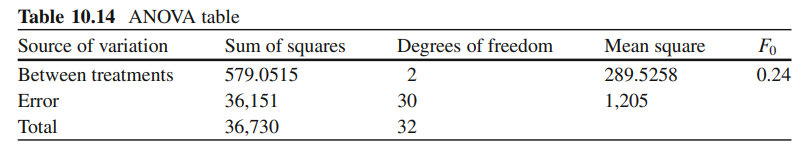

##### ANOVA description:
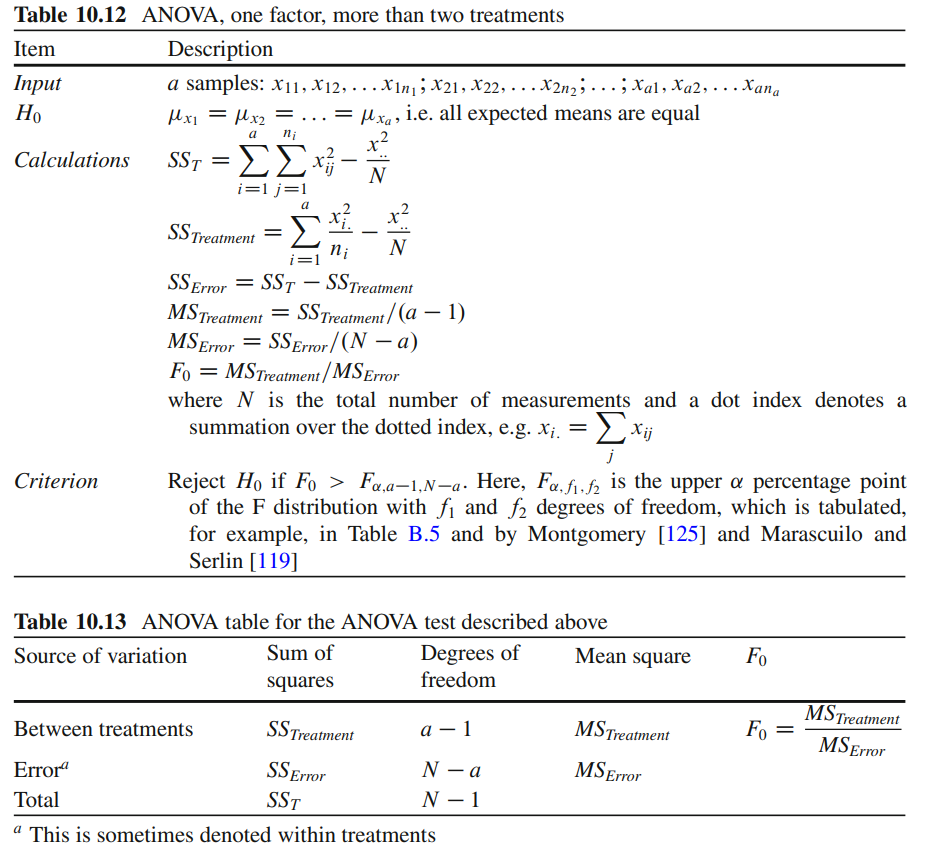
###### C. Wohlin, et al, Experimentation in Software Engineering. Berlin, Heidelberg: Springer Berlin Heidelberg, 2024. doi: 10.1007/978-3-662-69306-3.

---

### Questions:

##### Do we use *repeated measures* (rm) -ANOVA or rm-**M**ANOVA (rm Multivariate ANOVA)?
The choice depends on how we want to treat the DVs (dependent variables).

**We could:**

- analyze all treatments going metric-by-metric.
- compare means between samples (dependent variables).
- this would use **rm-ANOVA**.

**Alternatively, for:**

- **RQ1:** we consider all efficacy metrics as interconnected.
  - i.e., we compare them as some vector that with values that influence each other.
  - Have not loooked into details on the exact math, there's a formula.
  - Using **rm Multivariate ANOVA**
    - **Q**: is this then using dataset as a factor?


- **RQ2:** (*time* and *max_VRAM_usage*) we go metric-by-metric.
  - they do not directly influence each another.
  - **rm-ANOVA** or **Friedman test**.


##### **If assumptions break**; we could use the **Friedman** test?
  - non-parametric alternative to rm-ANOVA.
  - compares means across treatment sample (10 iterations).

Uses something called Chi Square method.
**Example:** categorical chi square ([Wikipedia source](https://en.wikipedia.org/wiki/Chi-squared_test))

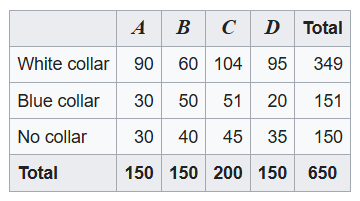

"The procedure involves ranking each row (or block) together, then considering the values of ranks by columns." - 
[Wikipedia](https://en.wikipedia.org/wiki/Friedman_test): 

**Our data**

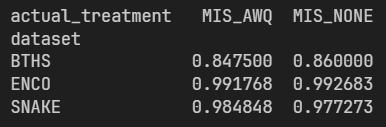

- We *block* data across rows - one per each dataset (datasets are *blocked* variables).
- Treatments as columns - **mean** value in cell per metric (dependent variable)  

---

**Option 1:**
- MANOVA for RQ1: the confusion matrix metrics are interconnected
- ANOVA for RQ2: these metrics are independent
  - we simplify to just: time, max vram usage

**Option 2:**
- Repeated Measures ANOVA for RQ1
- ANOVA for RQ2: same simplified dependent variables

**Option 3:**
- Friedman test for RQ1
- Friedman test for RQ2 with simplified DVs

In [12]:
import numpy as np
from scipy.stats import shapiro, levene, friedmanchisquare



### Univariate ANOVA assumption checks:

Shapiro-Wilks test (normality assumption)

In [13]:
def check_anova_normality(df: pd.DataFrame, metrics: list[str], print_results = True) -> dict:
    results = {} # Shapiro test results
    alpha = 0.05 # Significance level

    # Check each metric individually
    for metric in metrics:
        results[metric] = []

        if print_results: print(f"\nChecking assumptions for {metric.upper()}:")

        # Group by treatment
        for treatment in df["treatment"].unique():
            subset = df[df["treatment"] == treatment][metric]
            
            # Shapiro-Wilk test
            w, p = shapiro(subset)
            results[metric].append({treatment: [{"W": w, "p_value": p}]})

            # Print the result
            if print_results: 
                print(f"  Treatment: {treatment}")
                print(f"  Shapiro-Wilk p = {p:.4f} --> {'Pass' if p > alpha else 'Fail'} (normality)")

    return results

Check normality for RQ1: efficacy metrics

In [ ]:
_ = check_anova_normality(efficacy_long_df, RQ1_efficacy_metrics)


Checking assumptions for ACCURACY:
  Treatment: MIS_AWQ_BTHS
  Shapiro-Wilk p = 0.0000 --> Fail (normality)
  Treatment: MIS_AWQ_ENCO
  Shapiro-Wilk p = 0.0021 --> Fail (normality)
  Treatment: MIS_AWQ_SNAKE
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_NONE_BTHS
  Shapiro-Wilk p = 0.0000 --> Fail (normality)
  Treatment: MIS_NONE_ENCO
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_NONE_SNAKE
  Shapiro-Wilk p = 1.0000 --> Pass (normality)

Checking assumptions for RECALL:
  Treatment: MIS_AWQ_BTHS
  Shapiro-Wilk p = 0.0000 --> Fail (normality)
  Treatment: MIS_AWQ_ENCO
  Shapiro-Wilk p = 0.0002 --> Fail (normality)
  Treatment: MIS_AWQ_SNAKE
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_NONE_BTHS
  Shapiro-Wilk p = 0.0000 --> Fail (normality)
  Treatment: MIS_NONE_ENCO
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_NONE_SNAKE
  Shapiro-Wilk p = 1.0000 --> Pass (normality)

Checking assumptions for PRECISION:
  Treat

c:\Users\Erik\Documents\University\Year-3\BSc-Thesis\Repositories\Upstream REST-at\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Check normality for RQ2: efficiency metrics

In [ ]:
simple_efficiency_metrics = [
    "time_to_analyze",
    "vram_max_usage_mib"
]

_ = check_anova_normality(efficiency_long_df, simple_efficiency_metrics)


Checking assumptions for TIME_TO_ANALYZE:
  Treatment: MIS_AWQ_BTHS
  Shapiro-Wilk p = 0.0164 --> Fail (normality)
  Treatment: MIS_AWQ_ENCO
  Shapiro-Wilk p = 0.8446 --> Pass (normality)
  Treatment: MIS_AWQ_SNAKE
  Shapiro-Wilk p = 0.7515 --> Pass (normality)
  Treatment: MIS_NONE_BTHS
  Shapiro-Wilk p = 0.0461 --> Fail (normality)
  Treatment: MIS_NONE_ENCO
  Shapiro-Wilk p = 0.5152 --> Pass (normality)
  Treatment: MIS_NONE_SNAKE
  Shapiro-Wilk p = 0.0689 --> Pass (normality)

Checking assumptions for VRAM_MAX_USAGE_MIB:
  Treatment: MIS_AWQ_BTHS
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_AWQ_ENCO
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_AWQ_SNAKE
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_NONE_BTHS
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_NONE_ENCO
  Shapiro-Wilk p = 1.0000 --> Pass (normality)
  Treatment: MIS_NONE_SNAKE
  Shapiro-Wilk p = 1.0000 --> Pass (normality)


## Friedman test (chi square)

In [38]:
def run_friedman_test(df: pd.DataFrame, metric: str):
    alpha = 0.05

    # Copy dataframe to prevent modifying the original
    temp_df = df.copy()
    
    # Combine model and quant into "actual" treatment (simply: model + quant)
    temp_df["actual_treatment"] = df["model"] + "_" + df["quantization"]

    # Pivot data to fit the Friedman test:
    # - each row is a block (dataset)
    # - each col is a treatment (model + quant)
    # - each cell contains one value (mean of tested metric)
    pivot_df = temp_df.groupby(["dataset", "actual_treatment"])[metric].mean().unstack()
    
    # Extract treatment columns as separate arrays (one per treatment)
    treatments = [pivot_df[col].values for col in pivot_df.columns]

    #print(pivot_df.head())
    #print(treatments) 
    stat, p = friedmanchisquare(*treatments) # unroll list

    print(f"\nFriedman test for '{metric}':")
    print(f"  Statistic: {stat:.4f}, p-value: {p:.4f} --> {'Significant' if p < alpha else 'Not significant'}")

    return stat, p

In [37]:
#_, _ = run_friedman_test(long_df_efficacy, "accuracy")
run_friedman_test(efficacy_long_df, "accuracy")
## AAAAAAAAAAAAAA TEST IT WITH MORE DATA :(((

#TODO: fix "bug" -> test expects 3 input arrays (treatments iteration data - x10)

ValueError: At least 3 sets of samples must be given for Friedman test, got 2.